# Applying PerfectProg training to uWRF d02
# Scale by 4 (3km x4 = 12 km)


Don't need to do the first prep step for this because we already have it done. Now im using a new uWRF_match_dims function because the original one was working weird.

Then once we have the dimensions all set (time, latitude, longitude) we need to spatially filter it is divisble by 4.


In [33]:
import xarray as xr
import numpy as np
import ecubevis as ecv
import scipy as sp
import netCDF4 as nc

In [2]:
!python --version

Python 3.8.18


# Apply ML model 



In [7]:
uwrf_train = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-split/train/uWRF_final_01-02.nc')
uwrf_val = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-split/val/uWRF_final_03.nc')
uwrf_test = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-split/test/uWRF_final_03.nc')

nam_train = xr.open_dataset('/home/gvaillant1/aligned-data/aligned_nam_train_data.nc')
nam_val = xr.open_dataset('/home/gvaillant1/aligned-data/aligned_nam_test_data.nc')
nam_test = xr.open_dataset('/home/gvaillant1/aligned-data/aligned_nam_test_data.nc')

In [8]:
#High resolution (uWRF) data
T2_hr_train = uwrf_train.T2
T2_hr_val = uwrf_val.T2
T2_hr_test = uwrf_test.T2

PRES_hr_train = uwrf_train.PSFC
PRES_hr_val = uwrf_val.PSFC
PRES_hr_test = uwrf_test.PSFC

#--------------------------
#Low resolution (NAM) data
T2_lr_train = nam_train.T2
T2_lr_val = nam_val.T2
T2_lr_test = nam_test.T2

PRES_lr_train = nam_train.PSFC
PRES_lr_val = nam_val.PSFC
PRES_lr_test = nam_test.PSFC

In [9]:
import dl4ds as dds
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models

2025-01-06 09:49:23.437357: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-06 09:49:24.292343: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-06 09:49:24.294603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-06 09:49:32.874230: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
T2_scaler_train = dds.StandardScaler(axis=None)
T2_scaler_train.fit(T2_hr_train)  

PRES_scaler_train = dds.StandardScaler(axis=None)
PRES_scaler_train.fit(PRES_hr_train)
#----------------------------------------------
#High resolution (uWRF):
y_train = T2_scaler_train.transform(T2_hr_train)
y_val = T2_scaler_train.transform(T2_hr_val)
y_test = T2_scaler_train.transform(T2_hr_test)


y_z_train = PRES_scaler_train.transform(PRES_hr_train)
y_z_val = PRES_scaler_train.transform(PRES_hr_val)
y_z_test = PRES_scaler_train.transform(PRES_hr_test)

#-------------------------------------------------
#Low resolution (NAM)

x_train = T2_scaler_train.transform(T2_lr_train)
x_val = T2_scaler_train.transform(T2_lr_val)
x_test = T2_scaler_train.transform(T2_lr_test)

x_z_train = PRES_scaler_train.transform(PRES_lr_train)
x_z_val = PRES_scaler_train.transform(PRES_lr_val)
x_z_test = PRES_scaler_train.transform(PRES_lr_test)


In [11]:
y_train = y_train.expand_dims(dim='channel', axis=-1)
y_val = y_val.expand_dims(dim='channel', axis=-1)
y_test = y_test.expand_dims(dim='channel', axis=-1)

y_z_train = y_z_train.expand_dims(dim ='channel', axis=-1)
y_z_val = y_z_val.expand_dims(dim ='channel', axis=-1)
y_z_test = y_z_test.expand_dims(dim ='channel', axis=-1)

#-----------------------------------------------------

x_train = x_train.expand_dims(dim='channel', axis=-1)
x_val = x_val.expand_dims(dim='channel', axis=-1)
x_test = x_test.expand_dims(dim='channel', axis=-1)

x_z_train = x_z_train.expand_dims(dim ='channel', axis=-1)
x_z_val = x_z_val.expand_dims(dim ='channel', axis=-1)
x_z_test = x_z_test.expand_dims(dim ='channel', axis=-1)

In [12]:
print("T2 hr data shape:")
print(y_train.shape, y_val.shape, y_test.shape)
print("")
print("PRES hr data shape:")
print(y_z_train.shape, y_z_val.shape, y_z_test.shape)
print("")
print("T2 lr data shape:")
print(x_train.shape, x_val.shape, x_test.shape)
print("")
print("PRES lr data shape:")
print(x_z_train.shape, x_z_val.shape, x_z_test.shape)

T2 hr data shape:
(1537, 120, 120, 1) (870, 120, 120, 1) (870, 120, 120, 1)

PRES hr data shape:
(1537, 120, 120, 1) (870, 120, 120, 1) (870, 120, 120, 1)

T2 lr data shape:
(1537, 30, 30, 1) (450, 30, 30, 1) (450, 30, 30, 1)

PRES lr data shape:
(1537, 30, 30, 1) (450, 30, 30, 1) (450, 30, 30, 1)


HR array: (120, 120, 1), LR array (30, 30, 2)


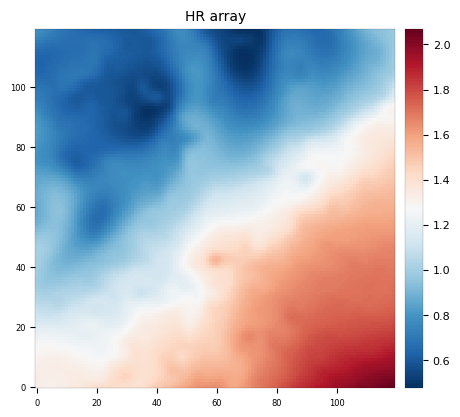

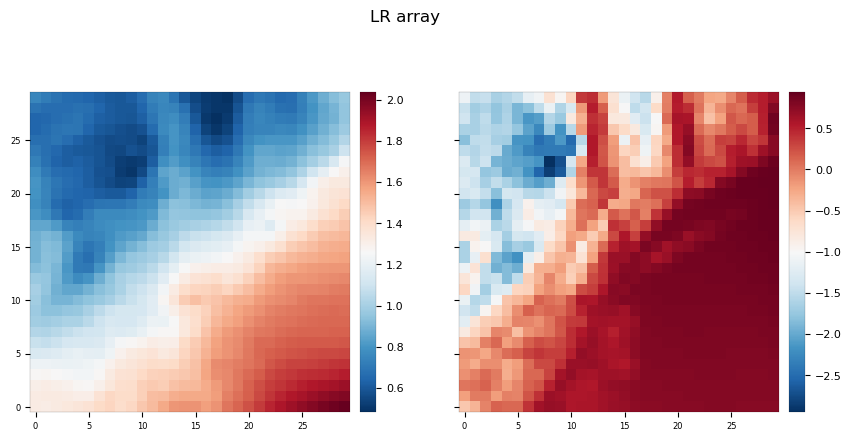

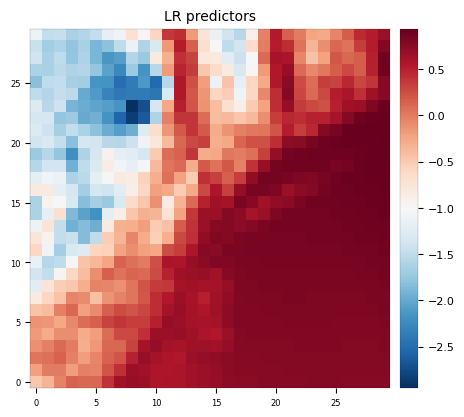

In [13]:
#Check for correct creation of the low-res version of uWRF
#This function is called before training begins. This is just an example to show what is going on:

_ = dds.create_pair_hr_lr(y_train.values[0], None, 'spc', 4, None, None, y_z_train.values[0], None, True, interpolation='inter_area')

In [14]:
ARCH_PARAMS = dict(n_filters=8,
                   n_blocks=8,
                   normalization=None,
                   dropout_rate=0.0,
                   dropout_variant='spatial',
                   attention=False,
                   activation='relu',
                   localcon_layer=False)

trainer = dds.SupervisedTrainer(
    backbone='resnet',
    upsampling='spc', 
    data_train=y_train,
    data_val=y_val,
    data_test=y_test,
    data_train_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    data_val_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    data_test_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    scale=4, 
    time_window=None, 
    static_vars=None,
    predictors_train=[y_z_train],
    predictors_val=[y_z_val],
    predictors_test=[y_z_test],
    interpolation='inter_area',
    patch_size=None, 
    batch_size=60, #changed from 60
    loss='mae',
    epochs=50, 
    steps_per_epoch=None, 
    validation_steps=None, 
    test_steps=None, 
    learning_rate=(1e-3, 1e-4), lr_decay_after=1e4,
    early_stopping=False, patience=6, min_delta=0, 
    save=False, 
    save_path=None,
    show_plot=True, verbose=True, 
    device='CPU',
    **ARCH_PARAMS)
trainer.run()


List of devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Number of devices: 1
Global batch size: 60
--------------------------------------------------------------------------------
Starting time: 2025-01-06 09:49:50
--------------------------------------------------------------------------------
Model: "resnet_spc"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                Output Shape                                 Param #        Connected to                                 
 input_1 (InputLayer)                        [(None, None, None, 2)]                      0              []                                           
                                                                                                                                                      
 conv2d (Conv2D)                             (None, 

In [15]:
pred = dds.Predictor(
    trainer, 
    y_test, 
    scale=4, 
    array_in_hr=False,
    static_vars=None, 
    predictors=[y_z_test], 
    time_window=None,
    interpolation='inter_area', 
    batch_size=64,
    scaler=T2_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_y_pred, coarsened_array = pred.run()

--------------------------------------------------------------------------------
Starting time: 2025-01-06 10:12:13
--------------------------------------------------------------------------------
14/14 [==============================] - 42s 3s/step
--------------------------------------------------------------------------------
Final running time: 0:00:44.767723
--------------------------------------------------------------------------------


In [16]:
pred1 = dds.Predictor(
    trainer, 
    x_val, 
    scale=4, 
    array_in_hr=False,
    static_vars=None, 
    predictors=[x_z_val], 
    time_window=None,
    interpolation='inter_area', 
    batch_size=4,
    scaler=T2_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_x_pred, coarsened_array1 = pred1.run()

--------------------------------------------------------------------------------
Starting time: 2025-01-06 10:12:58
--------------------------------------------------------------------------------
113/113 [==============================] - 2s 20ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:02.652012
--------------------------------------------------------------------------------


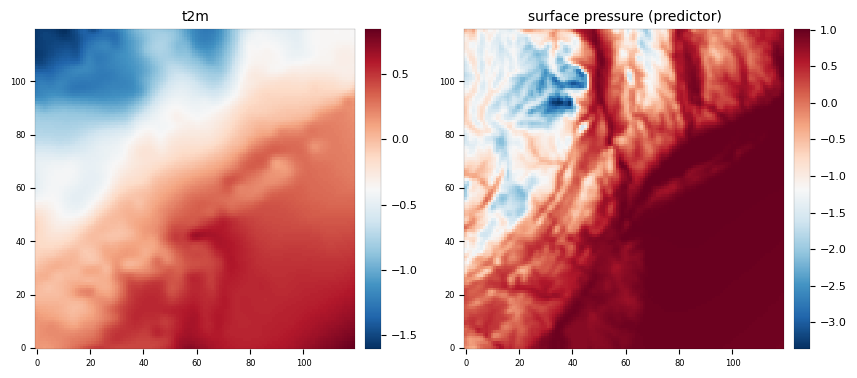

In [28]:
ind = 0
ecv.plot((coarsened_array[ind][:,:,0], coarsened_array[ind][:,:,1]), subplot_titles=('t2m', 'surface pressure (predictor)'),)

In [18]:
unscaled_y_test = T2_scaler_train.inverse_transform(y_test)

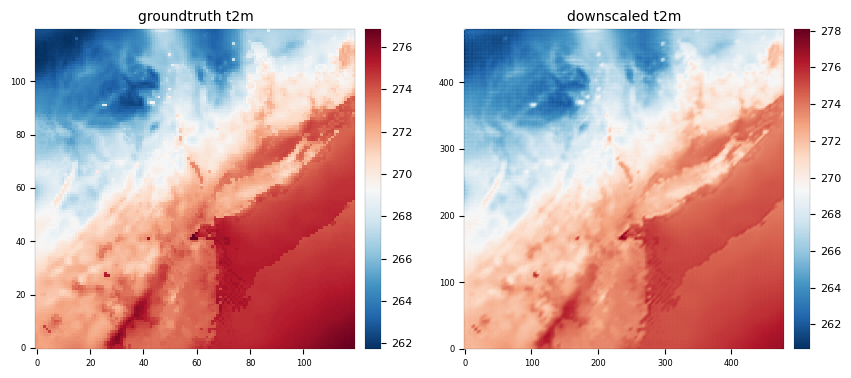

In [32]:
ecv.plot((unscaled_y_test[1].values, unscaled_y_pred[1]), subplot_titles=('groundtruth t2m', 'downscaled t2m'))

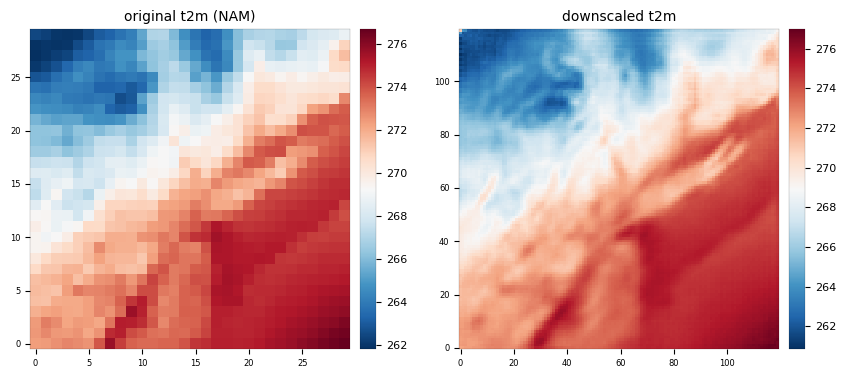

In [20]:
unscaled_x_test = T2_scaler_train.inverse_transform(x_test)
ecv.plot((unscaled_x_test[1].values, unscaled_x_pred[1]), subplot_titles=('original t2m (NAM)', 'downscaled t2m'))

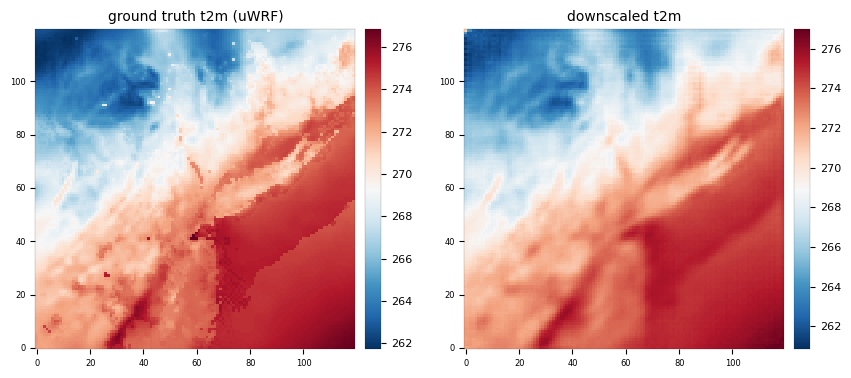

In [21]:
ecv.plot((unscaled_y_test[1].values, unscaled_x_pred[1]), subplot_titles=('ground truth t2m (uWRF)', 'downscaled t2m'))

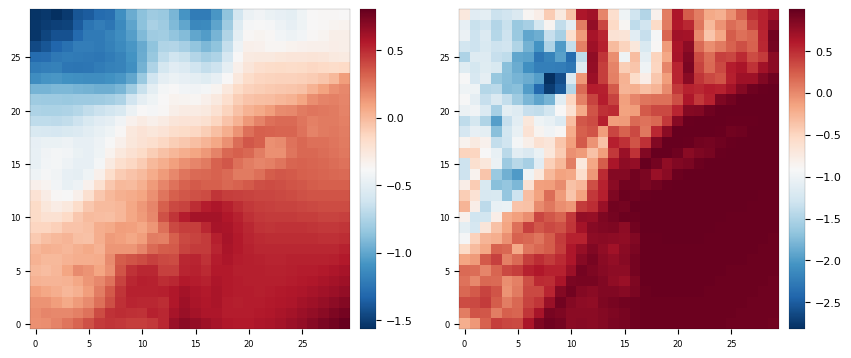

In [22]:
ind = 0
ecv.plot((coarsened_array1[ind][:,:,0], coarsened_array1[ind][:,:,1]))